# Investigating Latent Variable Models as a solution to Causal Overhypotheses

DiBS translates the task of inferring the posterior over Bayesian networks into an inference problem over the continuous latent variable $Z$. This is achieved by modeling the directed acyclic graph $G$ of the Bayesian network using the generative model $p(G | Z)$. The prior $p(Z)$ enforces the acyclicity of $G$.
Ultimately, this allows us to infer $p(G, \Theta | \mathcal{D})$ (and $p(G | \mathcal{D})$) using off-the-shelf inference methods such as Stein Variational gradient descent (SVGD) (Liu and Wang, 2016).

In [1]:
import yaml, pickle
from easydict import EasyDict
from copy import deepcopy

import bz2
import pickle
import _pickle as cPickle
from os.path import join

from pathlib import Path

import jax, gym
import jax.random as random
from jax import numpy as jnp
import numpy as np
import igraph
import matplotlib.pyplot as plt
import plotly.express as px
from adjustText import adjust_text
from scipy.special import softmax

from dibs.target import make_graph_model, Data
from dibs.models import DenseNonlinearGaussian, LinearGaussian
from dibs.utils import visualize_ground_truth, tree

from dibs.inference import MarginalDiBS, JointDiBS

from causal_env_v0 import CausalEnv_v0
from policy import RandomPolicy, FixedInterventionPolicy
from utils import collect_observational_data
from hypotheses import *

%load_ext autoreload
%autoreload 2

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
key = random.PRNGKey(123)
print(f"JAX backend: {jax.default_backend()}")

key, subk = random.split(key)

JAX backend: gpu


## Constants
* `NUM_SAMPLES` = Number of observation samples to collect
* `NUM_PARTICLES` = Number of particles to use for $Z$
* `N_VARS` = Number of nodes in SCM
* `PARTICLE_DIM` = Dimension of embedding. If `PARTICLE_DIM = N_VARS`, then embedding will be full-rank.

In [3]:
NUM_SAMPLES = 3000
NUM_PARTICLES = 40
N_VARS = 4
PARTICLE_DIM = 4

## Load environment & collect observational data

Define function to collect observational data from environment.

In [4]:
def make_data_env(env: gym.Env, num_samples: int, n_vars: int, env_config: dict, key: jnp.ndarray) -> Data:
    """Collect observational data from environment.

    Args:
        env (gym.Env): Environment to collect data from.
        num_samples (int): Number of samples to collect
        n_vars (int): Number of variables in the environment
        env_config (dict): environment configuration
        key (jnp.ndarray): JAX PRNG key

    Returns:
        Data: Returns a Data object containing the collected data
    """

    # initialize random policy
    random_policy = RandomPolicy(action_space=env.action_space)

    # Create numpy array to store training data
    x = np.zeros((num_samples, n_vars))

    # Define simple method to collect training data
    def store_state(
        *, state, action, next_state, reward, done, info, t_step, store_eps_info
    ) -> None:
        obs = np.concatenate([action, next_state[-1:]]).astype(np.float32) + \
                            np.random.normal(0, 0.1, n_vars)
        assert obs.shape[0] == n_vars, "Observation shape does not match n_vars!"
        x[t_step, :] = obs

    # collect training (observational) data from environment
    collect_observational_data(
        env_config=env_config,
        num_samples=num_samples,
        store_observational_data_callback=store_state,
        store_eps_info=False,
        policy=random_policy,
    )

    # Repeat for holdout & intervention data
    x_ho = np.zeros((num_samples, n_vars))

    def store_state(
        *, state, action, next_state, reward, done, info, t_step, store_eps_info
    ) -> None:
        obs = np.concatenate([action, next_state[-1:]]).astype(np.float32) + \
                            np.random.normal(0, 0.1, n_vars)
        assert obs.shape[0] == n_vars, "Observation shape does not match n_vars!"
        x_ho[t_step, :] = obs

    collect_observational_data(
        env_config=env_config,
        num_samples=num_samples,
        store_observational_data_callback=store_state,
        store_eps_info=False,
        policy=random_policy,
    )

    x_interv = []
    def store_state(
        *, state, action, next_state, reward, done, info, t_step, store_eps_info
    ) -> None:
        x_interv.append((action, np.concatenate([action, next_state[-1:]]).astype(np.float32)
        ))

    collect_observational_data(
        env_config=env_config,
        num_samples=num_samples,
        store_observational_data_callback=store_state,
        store_eps_info=False,
        policy=random_policy,
    )

    data = Data(
        passed_key=key,
        n_vars=n_vars,
        n_observations=num_samples,
        n_ho_observations=num_samples,
        g=jnp.array(A),                 # NOTE: Can be arbitrary adjacency matrix.
        theta=None,
        x=x,
        x_ho=x_ho,
        x_interv=x_interv,
    )

    return data

In [5]:
# Load env config
with open('config/env_config.yaml', "r") as f:
    env_config = EasyDict(yaml.load(f, Loader=yaml.FullLoader))
    ldict = {}
    exec(env_config.hypotheses, globals(), ldict)
    env_config.hypotheses = ldict["hypotheses"]

env = CausalEnv_v0(env_config)
agent = RandomPolicy(action_space=env.action_space)

data = make_data_env(env=env, num_samples=NUM_SAMPLES, n_vars=N_VARS, env_config=env_config, key=key)
print(f"Hypotheses:\n{env_config.hypotheses}")

Hypotheses:
[<class 'causal_env_v0.Adisj'>, <class 'causal_env_v0.Bdisj'>, <class 'causal_env_v0.ABconj'>, <class 'causal_env_v0.BCconj'>]


## Generate BN model for inference and graph prior

Uniform graph prior with `n_vars` nodes and expected number of edges per node set. Sampling from the prior is done by rejection sampling (naive method).

`inference_model` defines prior $p(G, \Theta)$ and likelihood $p(x | G, \Theta)$ of the BN model for which DiBS will infer the posterior. Since our environment is non-linear Gaussian additive noise model (ANM), the nonlinear Gaussian networks are modeled by parameterized fully-connected neural networks over which posterior inference is performed.

In [6]:
graph_dist = make_graph_model(n_vars=N_VARS, graph_prior_str="", edges_per_node=1)
inference_model = DenseNonlinearGaussian(hidden_layers=[5, 5], activation="sigmoid", graph_dist=graph_dist)

dummy_subkeys = jnp.zeros((N_VARS, 2), dtype=jnp.uint32)
_, dummy_theta = inference_model.eltwise_nn_init_random_params(dummy_subkeys, (N_VARS, ))
print(f"Inference model parameters shape: {inference_model.get_theta_shape(n_vars=N_VARS)}")

Inference model parameters shape: [(Array([4, 4, 5], dtype=int32), Array([4, 5], dtype=int32)), (), (Array([4, 5, 5], dtype=int32), Array([4, 5], dtype=int32)), (), (Array([4, 5, 1], dtype=int32), Array([4, 1], dtype=int32))]


## DiBS with SVGD

Infer $p(G, \Theta | D)$ under the prior and conditional distributions defined by `model`.
The below visualization shows the *matrix of edge probabilities* $G_\alpha(Z^{(k)})$ implied by each transported latent particle (i.e., sample) $Z^{(k)}$ during the iterations of SVGD with DiBS. Refer to the paper for further details.

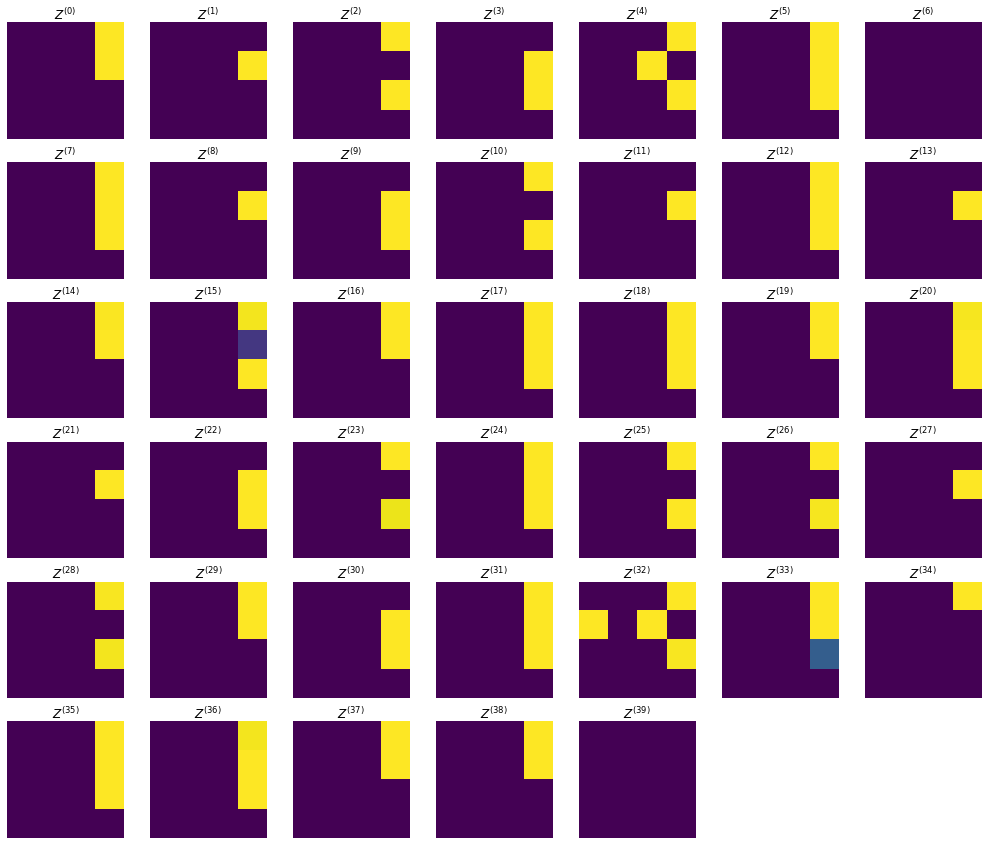

iteration   2000 | alpha  100.0 | beta 2000.0 | #cyclic   0


In [7]:
inter_mask = np.concatenate([np.ones((NUM_SAMPLES, 3)), np.zeros((NUM_SAMPLES, 1))], axis=-1).astype(np.int32)
dibs = JointDiBS(x=data.x, interv_mask=inter_mask, inference_model=inference_model, verbose=True)
key, subk = random.split(key)

gs, theta, z = dibs.sample(key=subk, n_particles=NUM_PARTICLES, steps=2000, callback_every=20, return_z=True, callback=dibs.visualize_callback(), n_dim_particles=PARTICLE_DIM)

### Reshape $\Theta$ for easy use with log likelihood functions later 

In [8]:
def reshape_theta(theta):
    """Reshape theta to be a list of length NUM_PARTICLES, where each element is a list of length len(theta)"""
    thetas = []
    for k in range(NUM_PARTICLES):
        single_theta = []
        for i in range(len(theta)):
            if len(theta[i]) > 0:
                single_theta.append((theta[i][0][k, ...], theta[i][1][k, ...]))
            else:
                single_theta.append(tuple([]))
        thetas.append(single_theta)
    return thetas

In [9]:
thetas = reshape_theta(theta)

In [10]:
# Compute the log likelihood of a graph given the sampled latent parameters
def compute_log_likelihood(z, t=2000):
    p_g_z = {}
    for name, G in zip(['A', 'B', 'C', 'AB', 'BC', 'CA', 'ABC'], [A, B, C, AB, BC, CA, ABC]):
        p_g_z[name] = np.zeros((NUM_PARTICLES,))
        for i in range(NUM_PARTICLES):
            p_g_z[name][i] = dibs.latent_log_prob(G, z[i, ...], t=t)
            print(f"log p({name} | Z_{i}) = {p_g_z[name][i]}")
        print()
    return p_g_z

For each possible hypotheses $G$, find the top-$k$ $Z^{(i)}$'s with the highest log likelihood of generative graph model i.e.,
$$
\argmax_{I, |I| = k} \log p( G | Z^{(i \in I)} )
$$.

In [11]:
# Identify the best particles for each hypotheses
def compute_best_particles(p_g_z, k=10):
    best_particles = {}
    for name, _ in zip(['A', 'B', 'C', 'AB', 'BC', 'CA', 'ABC'], [A, B, C, AB, BC, CA, ABC]):
        idx = np.argpartition(p_g_z[name], -k)[-k:][::-1]
        print(f"Top {k} particles for {name}: {idx}")
        best_particles[name] = idx
    return best_particles

In [12]:
best_particles = compute_best_particles(compute_log_likelihood(z, t=2000), k=10)

log p(A | Z_0) = -10.635376930236816
log p(A | Z_1) = -38.3453254699707
log p(A | Z_2) = -16.045076370239258
log p(A | Z_3) = -47.94939422607422
log p(A | Z_4) = -33.567138671875
log p(A | Z_5) = -25.537403106689453
log p(A | Z_6) = -15.854743957519531
log p(A | Z_7) = -14.980347633361816
log p(A | Z_8) = -28.633575439453125
log p(A | Z_9) = -56.38249969482422
log p(A | Z_10) = -6.746598720550537
log p(A | Z_11) = -42.03302764892578
log p(A | Z_12) = -22.390348434448242
log p(A | Z_13) = -26.681446075439453
log p(A | Z_14) = -8.796314239501953
log p(A | Z_15) = -14.601359367370605
log p(A | Z_16) = -23.979379653930664
log p(A | Z_17) = -23.503114700317383
log p(A | Z_18) = -36.966304779052734
log p(A | Z_19) = -10.796956062316895
log p(A | Z_20) = -21.19434928894043
log p(A | Z_21) = -26.15057373046875
log p(A | Z_22) = -62.160160064697266
log p(A | Z_23) = -3.5371456146240234
log p(A | Z_24) = -23.97022247314453
log p(A | Z_25) = -5.939454555511475
log p(A | Z_26) = -4.352841854095459

### Mixture Distributions $\log p(G, \Theta | Z^{(i)})$

Form the empirical (i.e., weighted by counts) and mixture distributions (i.e., weighted by unnormalized posterior probabilities, denoted DiBS+).

In [13]:
# plot marginal log likelihoods of each particle
def plot_marginal_log_likelihoods(gs, theta):
	dibs_mixture = dibs.get_mixture(gs, theta)
	for idx, logp_z in enumerate(dibs_mixture.logp):
		print(f"log p(G, theta | z_{idx}): {logp_z}")

	fig, ax = plt.subplots(1, 1, figsize=(10, 5))
	ax.scatter(np.arange(NUM_PARTICLES), dibs_mixture.logp)
	ax.set_xticks(np.arange(NUM_PARTICLES))
	ax.set_xticklabels(np.arange(NUM_PARTICLES), rotation=90)
	ax.set_xlabel("Particle index "+r"$i$")
	ax.set_ylabel(r"$\log p(G, \Theta | Z^{(i)})$")
	ax.set_title("Mixture log likelihood " + r"$\log p(G, \Theta | Z^{(i)})$")
	plt.show()

log p(G, theta | z_0): -185.2022705078125
log p(G, theta | z_1): -557.8856201171875
log p(G, theta | z_2): -1228.3038330078125
log p(G, theta | z_3): -333.255859375
log p(G, theta | z_4): -1226.5802001953125
log p(G, theta | z_5): -12.254638671875
log p(G, theta | z_6): -1662.6507568359375
log p(G, theta | z_7): -21.79931640625
log p(G, theta | z_8): -547.2569580078125
log p(G, theta | z_9): -355.70556640625
log p(G, theta | z_10): -1226.3070068359375
log p(G, theta | z_11): -542.4539794921875
log p(G, theta | z_12): -8.5191650390625
log p(G, theta | z_13): -539.4359130859375
log p(G, theta | z_14): -198.1444091796875
log p(G, theta | z_15): -1225.2286376953125
log p(G, theta | z_16): -221.1917724609375
log p(G, theta | z_17): -16.317138671875
log p(G, theta | z_18): -15.1866455078125
log p(G, theta | z_19): -203.7215576171875
log p(G, theta | z_20): -0.00048828125
log p(G, theta | z_21): -526.6842041015625
log p(G, theta | z_22): -351.578857421875
log p(G, theta | z_23): -1242.9693603

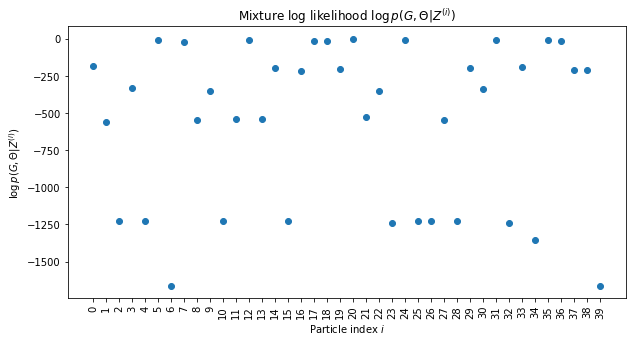

In [14]:
plot_marginal_log_likelihoods(gs, theta)

## Compute Node embedding similarity

DiBS, similar to Graph Variational Auto-Encoders (GVAE), decomposes the latent variable as $Z = U^\top V$ where $Z \in \mathbb{R}^{d \times d}$, $U \in \mathbb{R}^{d \times K}$, and $V \in \mathbb{R}^{d \times K}$. Here, $d$ is the nodes in the BN and $K$ is an embedding dimension.

Hence, the columns $u_i \in U$ and $v_i \in V$ can be thought of as node embeddings as each entry $g_{i, j}$ in adjacency matrix of $G$ is given by $g_{i, j} = \sigma(v_i^\top u_j)$.

Here, we construct node embedding $n_i$ for node $i$ by concatenating the two column vectors $n_i = [u_i, v_i]$. Then, we compute the cosine distance between the the node embedding with all other nodes, giving us a symmetric matrix $M$ where each entry is given by $m_{i, j} = \frac{n_i \cdot n_j^\top}{ || n_i || \cdot ||n_j||}$.

In [15]:
def m3(u, v):
    grid = np.zeros((NUM_PARTICLES, N_VARS, N_VARS))

    for k in range(NUM_PARTICLES):
        for i in range(N_VARS):
            for j in range(N_VARS):
                Z = jnp.concatenate([u[k, i, :], v[k, i, :]], axis=0)
                Z_norm = jnp.expand_dims(jnp.linalg.norm(Z), axis=0)

                B = jnp.concatenate([u[k, j, :], v[k, j, :]], axis=0).T
                B_norm = jnp.expand_dims(jnp.linalg.norm(B), axis=0)

                cosine_similarity = ((Z @ B.T) / (Z_norm @ B_norm)).T
                cosine_distance = 1 - cosine_similarity
                grid[k, i, j] = cosine_distance
    return grid

def plot_grid(grid, n_cols=7, size=2.5):
    N = grid.shape[0]
    n_rows = N // n_cols
    if N % n_cols:
        n_rows += 1

    plt.rcParams['figure.figsize'] = [size * n_cols, size * n_rows]
    fig, axs = plt.subplots(n_rows, n_cols)
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        if i < N:
            ax.matshow(grid[i, :, :])
            ax.tick_params(axis='both', which='both', length=0)
            ax.set_title(r'$Z^{('f'{i}'r')}$', pad=3)
        ax.tick_params(axis='both', which='both', length=0)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.axis('off')

    plt.show()

### Split $Z$ into $\{U, V\}$ and compute cosine distance between embeddings

In [16]:
u, v = z[..., 0], z[..., 1]
scores = jnp.einsum('...ik,...jk->...ij', u, v)

grid = m3(u, v)

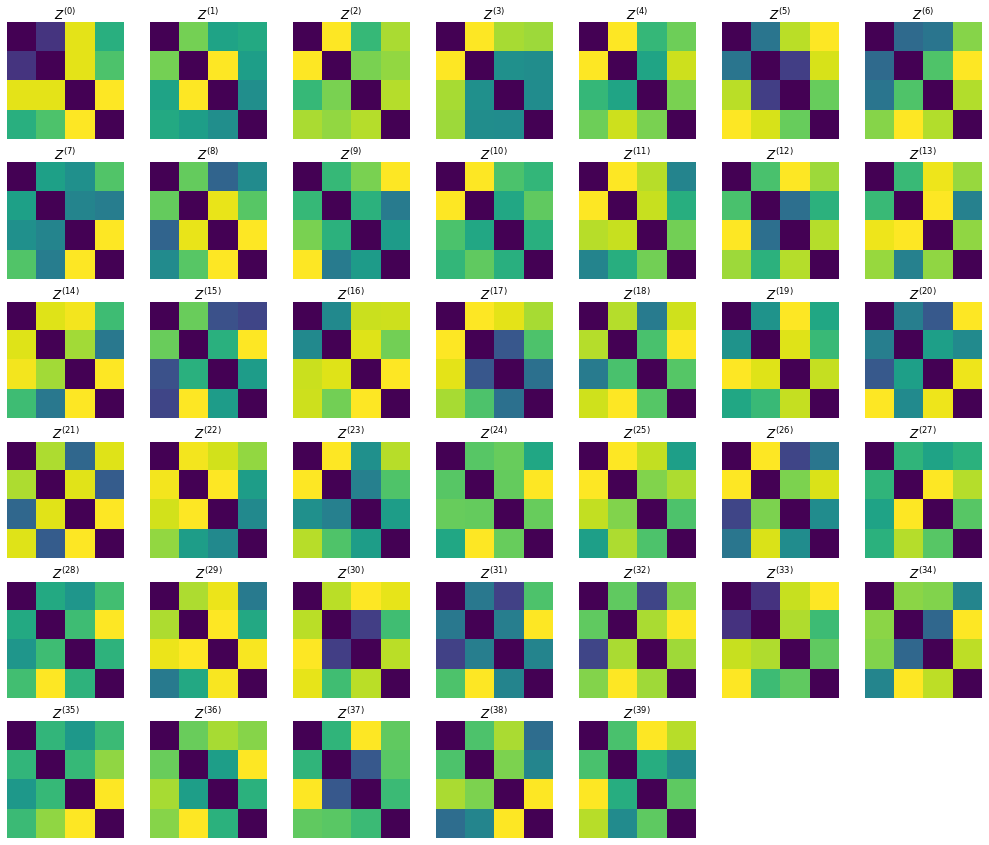

In [17]:
plot_grid(grid)

### Compute some evaluation metrics.

In [18]:
def eval_dibs(gs, theta):
    from dibs.metrics import expected_shd, threshold_metrics, neg_ave_log_likelihood

    dibs_empirical = dibs.get_empirical(gs, theta)
    dibs_mixture = dibs.get_mixture(gs, theta)
    for descr, dist in [('DiBS ', dibs_empirical), ('DiBS+', dibs_mixture)]:

        eshd = expected_shd(dist=dist, g=data.g)
        auroc = threshold_metrics(dist=dist, g=data.g)['roc_auc']
        negll = neg_ave_log_likelihood(dist=dist, x=data.x_ho,
                    eltwise_log_likelihood=dibs.eltwise_log_likelihood_observ)

        print(f'{descr} |  E-SHD: {eshd:4.1f}    AUROC: {auroc:5.2f}    neg. MLL {negll:5.2f}')

In [19]:
eval_dibs(gs, theta)

DiBS  |  E-SHD:  1.7    AUROC:  0.97    neg. MLL 22492.45
DiBS+ |  E-SHD:  2.0    AUROC:  0.93    neg. MLL 21981.81


## Investigate Latent particles $Z^{(i)}$

### Projection via UMAP to 2D space

In [20]:
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import pandas as pd
import plotly.express as px

In [21]:
def particle_to_u_v_z_idx(z):
	"""Convert particles Z to components U and V. Stack as single vector.
	Also return particle indices."""
	u, v = z[..., 0], z[..., 1]

	X = np.zeros((NUM_PARTICLES, N_VARS, PARTICLE_DIM*2))
	Y = np.zeros((NUM_PARTICLES, N_VARS, 1))
	Z = np.zeros((NUM_PARTICLES, N_VARS, 1))
	for k in range(NUM_PARTICLES):
		for i in range(N_VARS):
			X[k, i, :] = np.concatenate([u[k, i, :], v[k, i, :]], axis=0)
			Y[k, i, :] = i
			Z[k, i, :] = k
	return X.reshape(-1, PARTICLE_DIM*2), Y.reshape(-1).astype(int), Z.reshape(-1).astype(int)

In [22]:
# X: node embeddings
# Y: node labels
# Zidx: particle indices
X, Y, Zidx = particle_to_u_v_z_idx(z)

In [23]:
def plot_embeddings(embedding, Y, label_frmt, method, point_labels=None, filter_=None):
	plt.figure(figsize=(8, 8), dpi=300)

	for g in np.unique(Y):
		idx = np.where(Y == g)
		x, y = embedding[idx, 0], embedding[idx, 1]
		plt.scatter(x, y, s=25, label=label_frmt.format(int(g)), cmap='tab10')

	texts = []
	# Annotate some points in the scatter plot
	if point_labels is not None:

		# for each point plotted
		for idx in range(embedding.shape[0]):
			# if that index is to be annotated
			if point_labels[idx] in filter_:
				texts.append(
					plt.text(embedding[idx, 0], embedding[idx, 1], r"$Z^{("+f"{int(point_labels[idx])}"+r")}$")
				)

	adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))
	plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
	plt.title(f'Projection of Node Embeddings by {method}')
	plt.tight_layout()


Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'callable': Cannot determine Numba type of <class 'builtin_function_or_method'>

File "../../../envs/work/lib/python3.9/site-packages/umap/umap_.py", line 346:
def fuzzy_simplicial_set(X, n_neighbors, metric, metric_kwds={}):
    <source elided>

    if callable(metric):
    ^


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'callable': Cannot determine Numba type of <class 'builtin_function_or_method'>

File "../../../envs/work/lib/python3.9/site-packages/umap/umap_.py", line 346:
def fuzzy_simplicial_set(X, n_neighbors, metric, metric_kwds={}):
    <source elided>

    if callable(metric):
    ^

Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True, but has lifted loops.

File "../../../

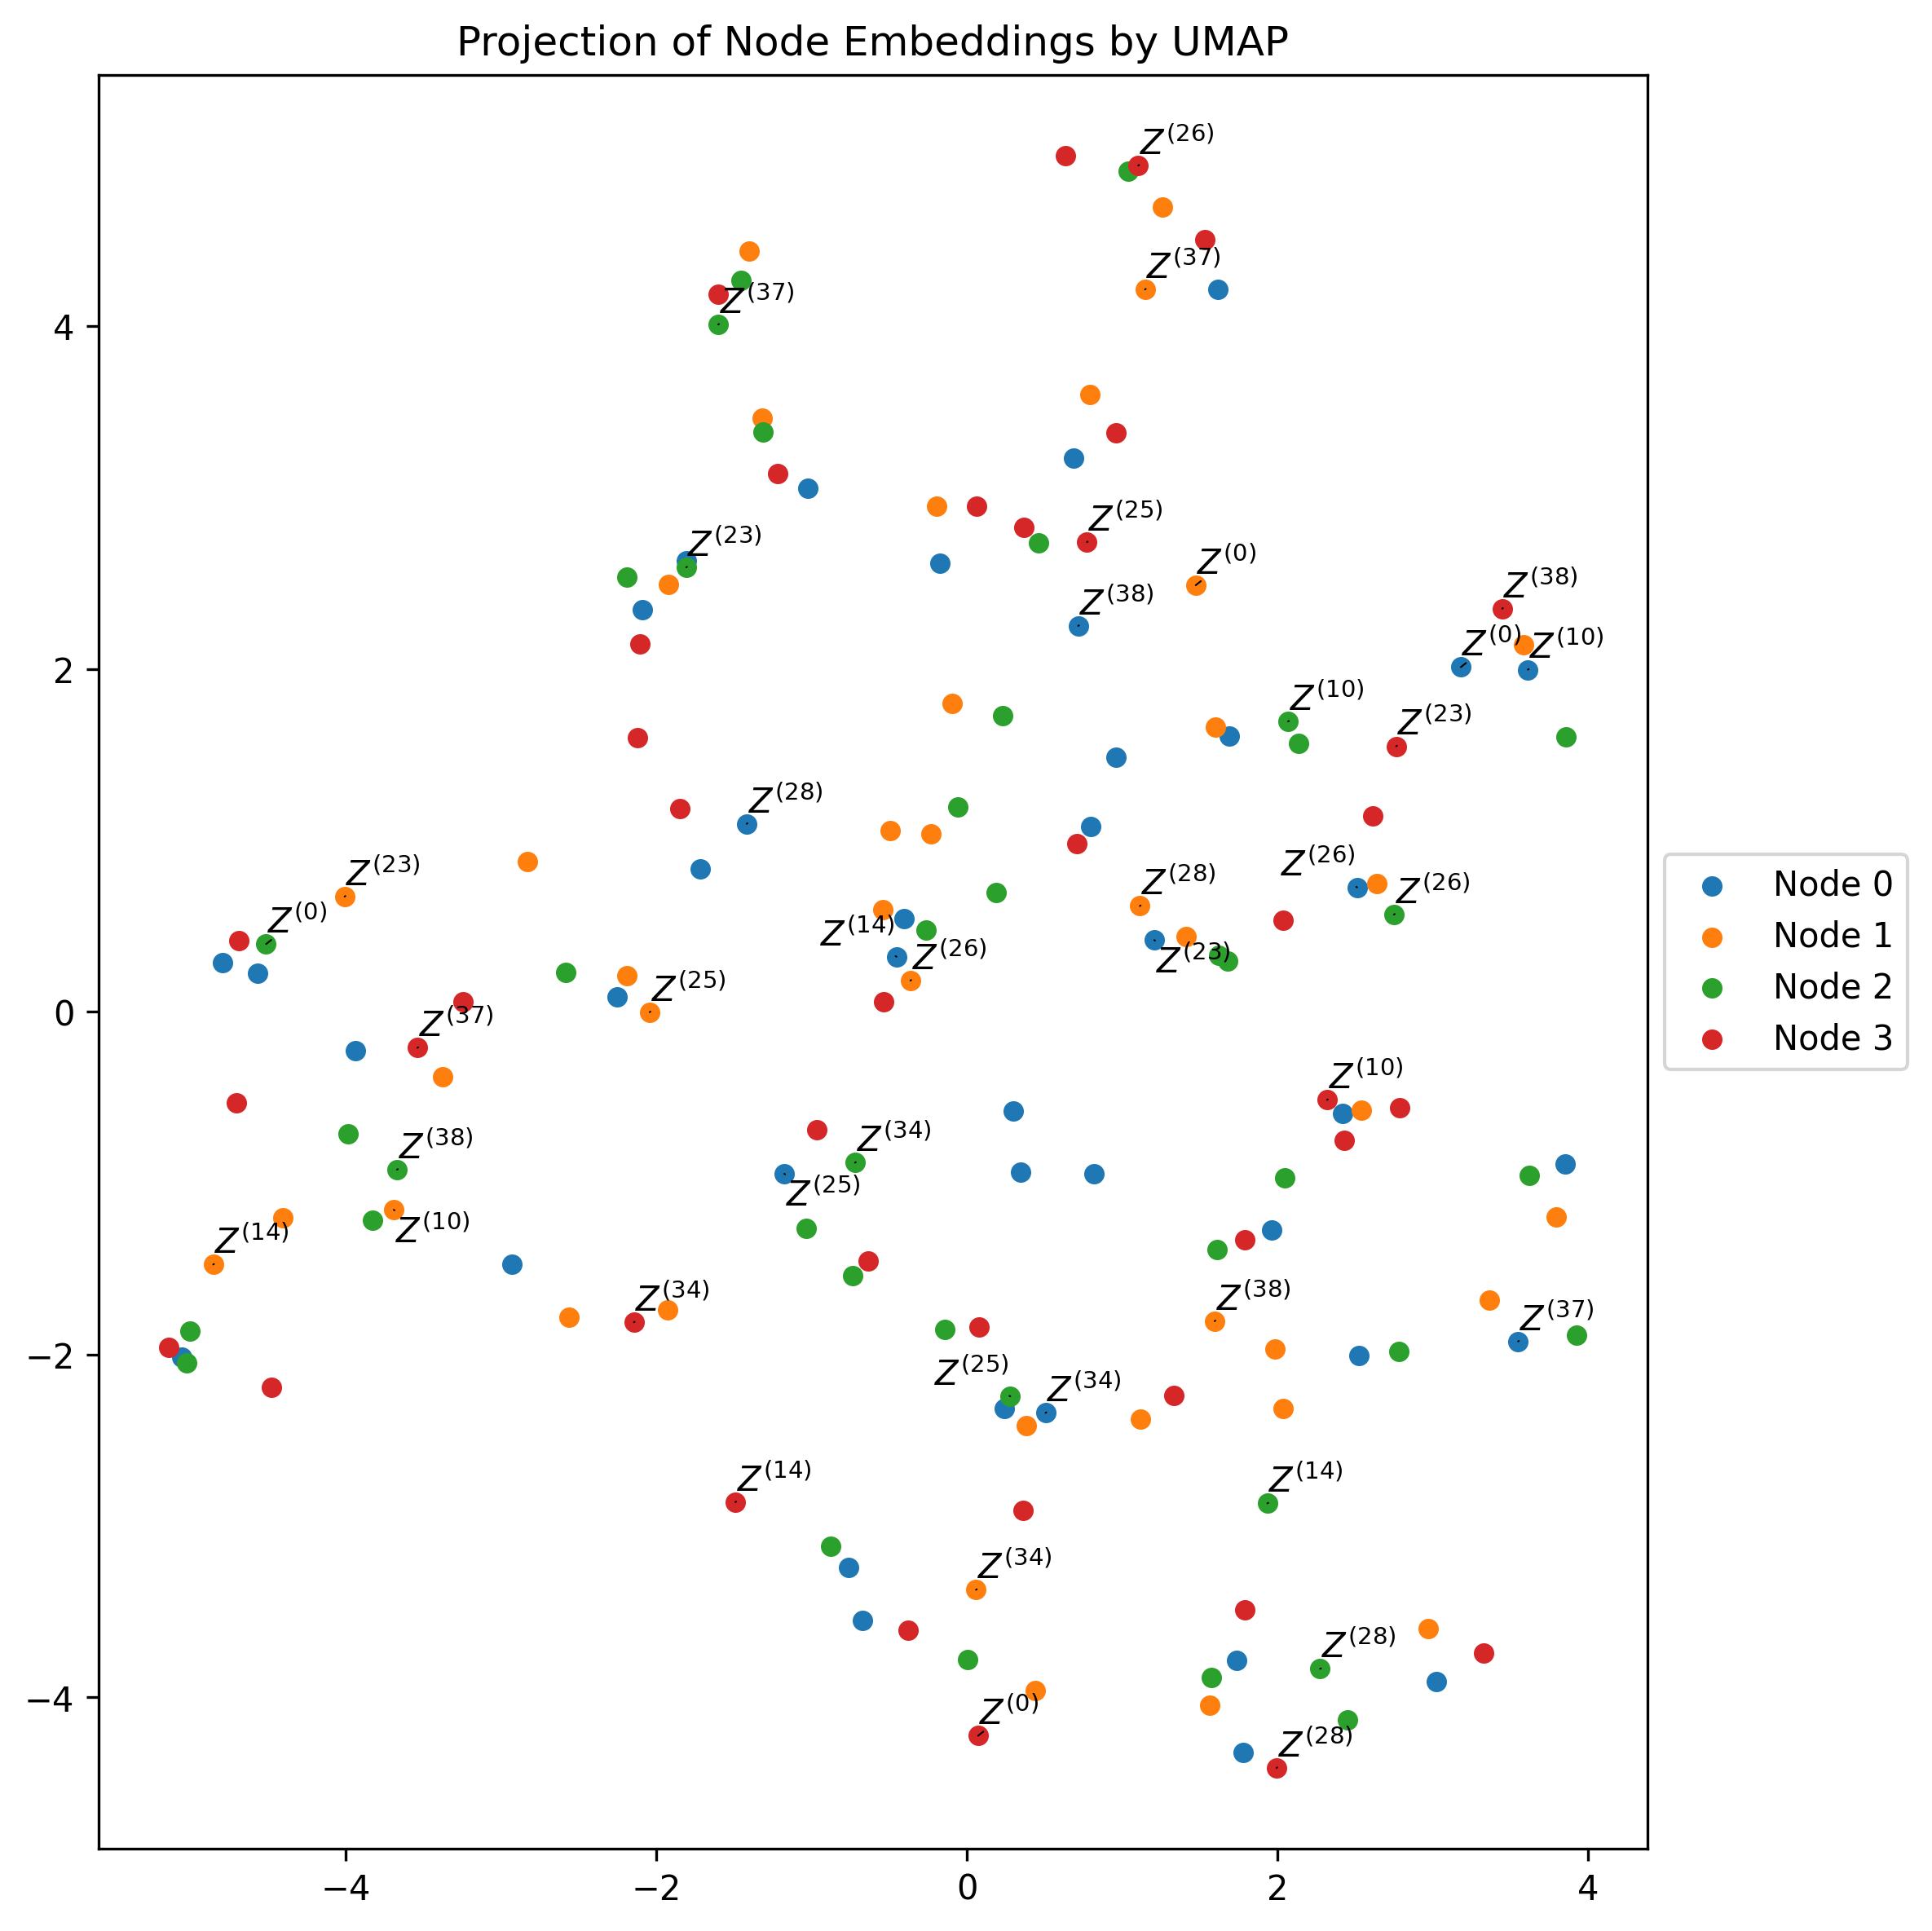

In [24]:
plot_embeddings(
    UMAP(n_neighbors=4, n_components=2).fit_transform(X),
    Y,
    label_frmt="Node {}",
    method="UMAP",
    point_labels=Zidx.astype(int),
    filter_=best_particles["A"],
)

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


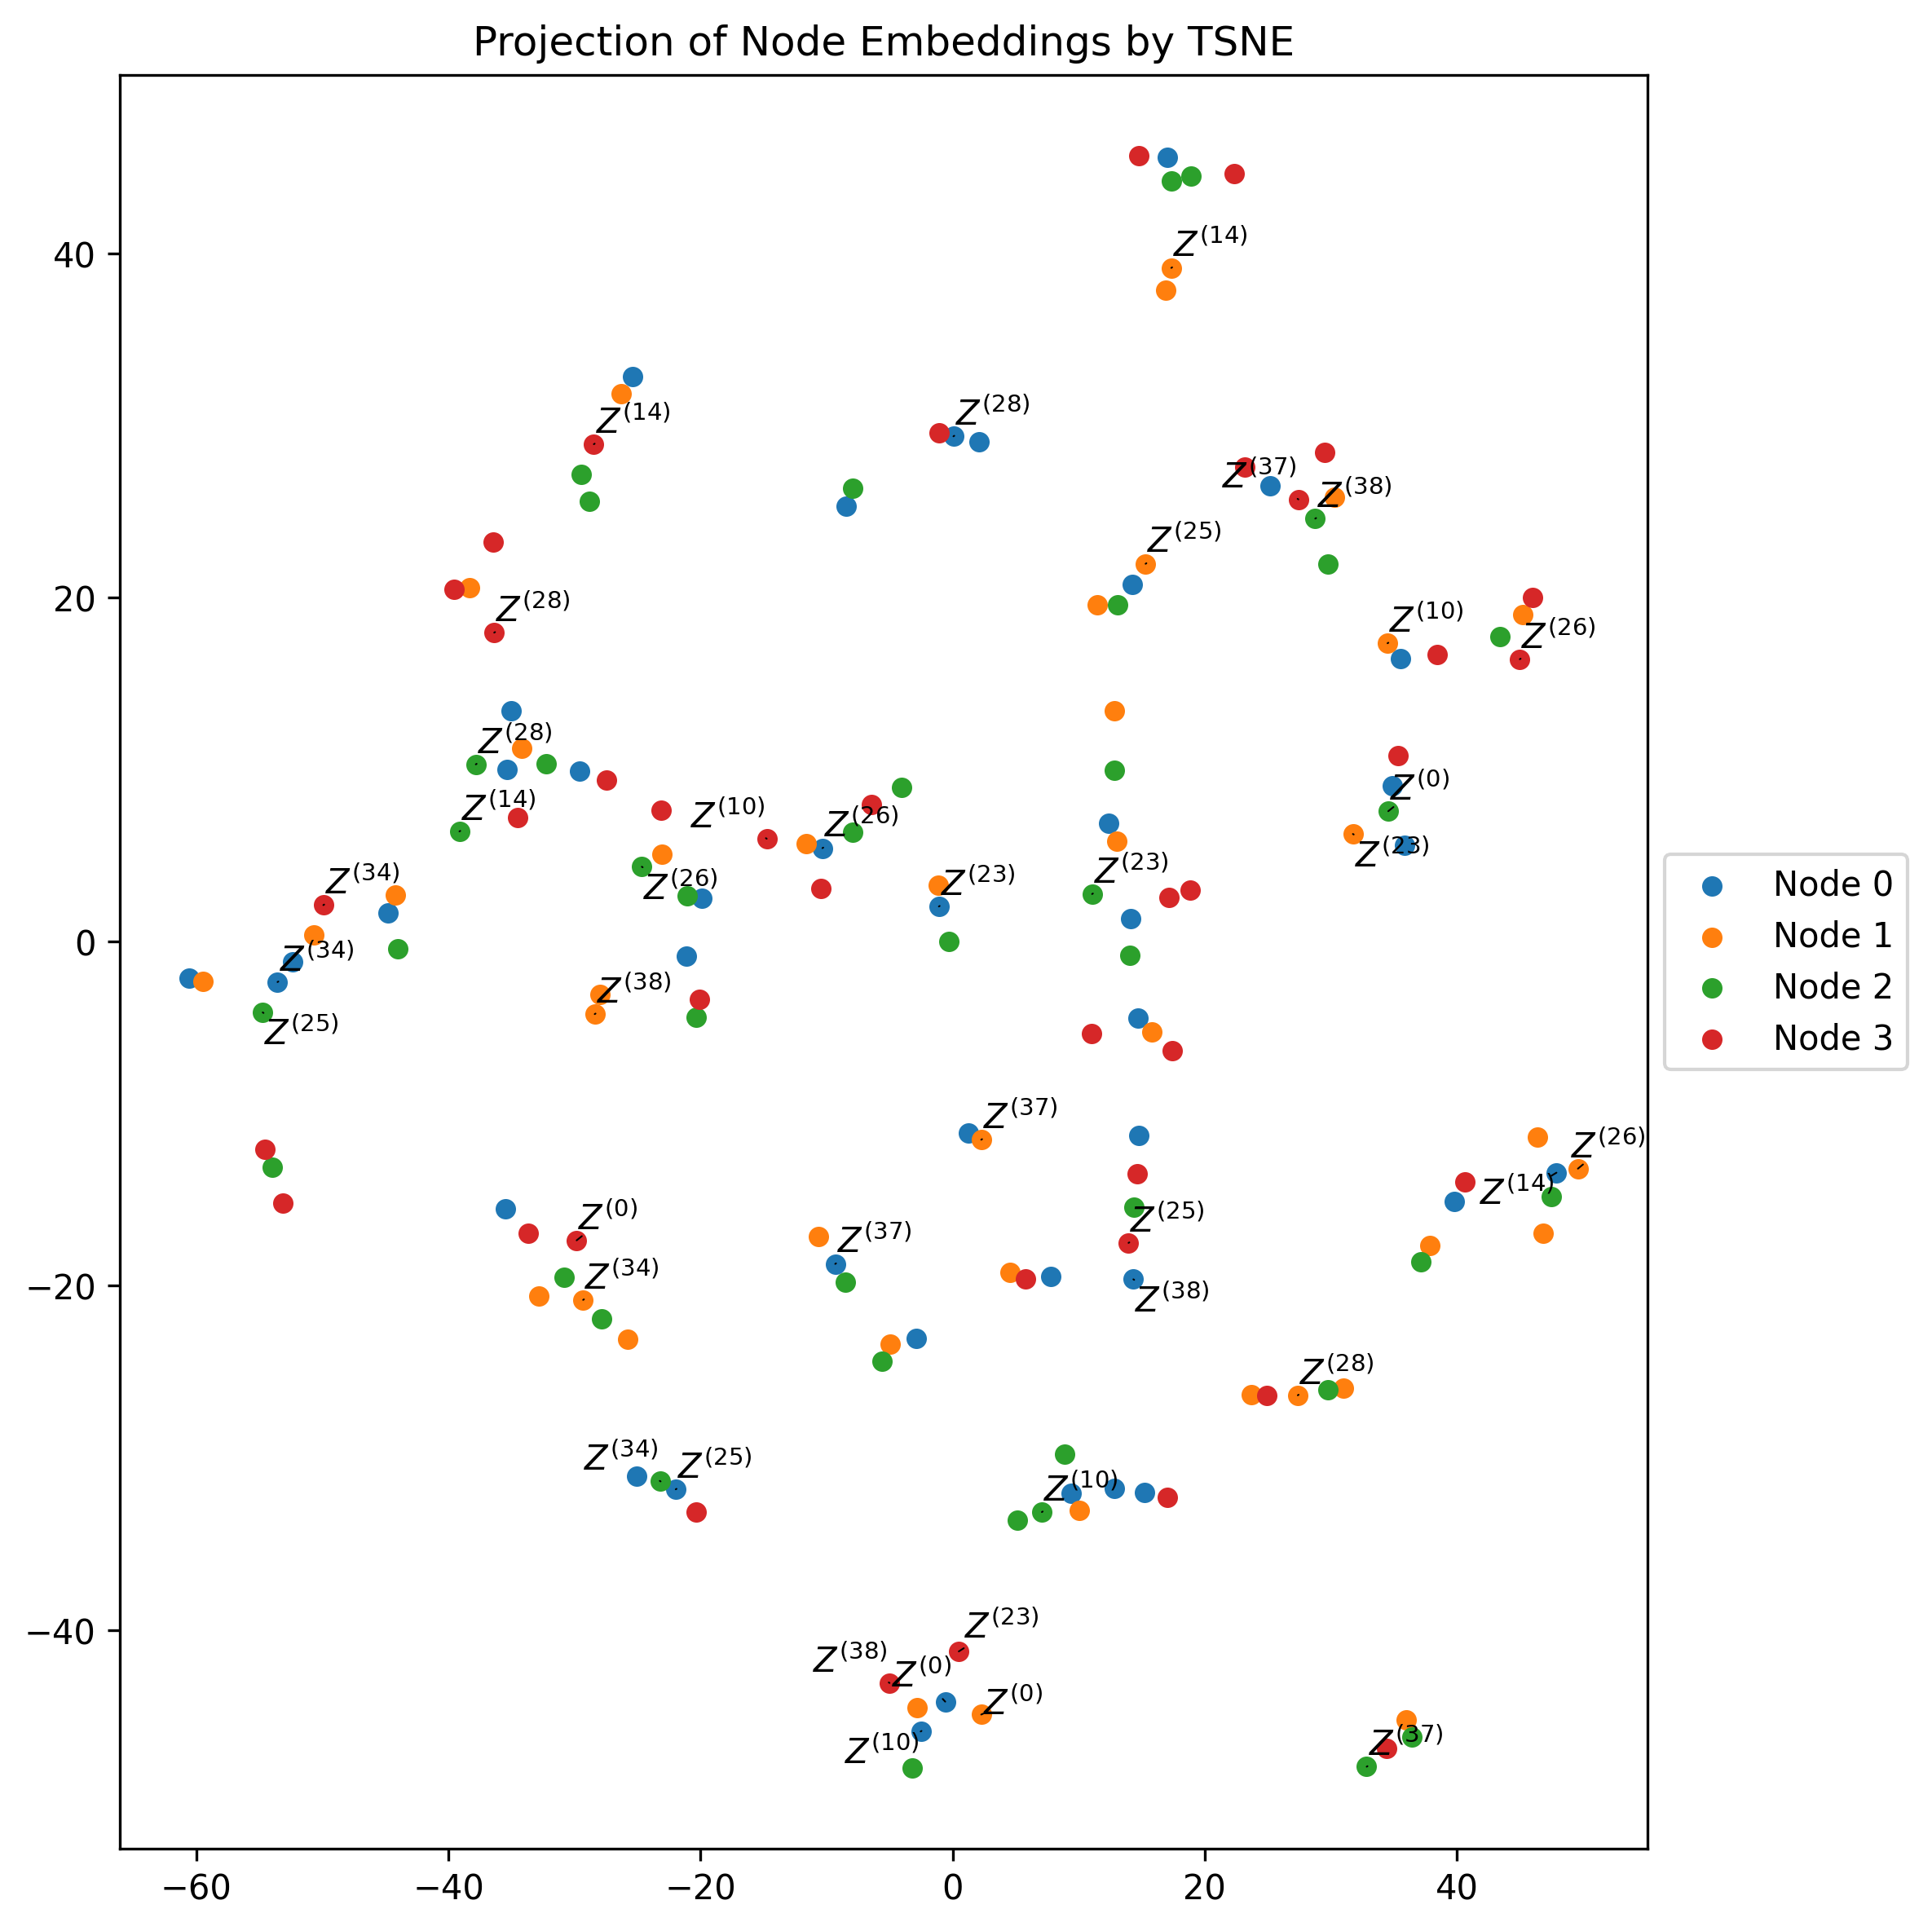

In [25]:
plot_embeddings(
    TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X),
    Y,
    label_frmt="Node {}",
    method="TSNE",
    point_labels=Zidx.astype(int),
    filter_=best_particles["A"],
)

In [55]:
best_particles

{'A': array([34, 23, 28, 10, 14, 26, 25, 37, 38,  0]),
 'B': array([ 8,  1, 13, 11, 27, 21, 14, 16, 38,  9]),
 'C': array([23, 15, 28,  9, 10,  3, 39,  2, 22, 26]),
 'AB': array([19,  0, 37, 29, 38, 16, 33, 14,  7, 20]),
 'BC': array([ 9, 20, 15, 36, 18,  3, 17, 30, 22, 31]),
 'CA': array([10,  2, 25, 15, 23, 28, 26, 12,  7, 17]),
 'ABC': array([12, 24, 17, 18, 35,  5, 31,  7, 20, 36])}

In [68]:
Y_g = np.zeros((NUM_PARTICLES, N_VARS, 1))
for i in range(NUM_PARTICLES):
	for g_idx, key in enumerate(best_particles):
		for idx in best_particles[key]:
			if i == idx:
				if g_idx == 0:
					Y_g[idx, :, :] = g_idx
				elif g_idx == 1:
					Y_g[idx, :, :] = g_idx
				else:
					Y_g[idx, :, :] = 2

In [69]:
Y_g = Y_g.reshape(-1).astype(int)

/tmp/ipykernel_1025110/3146864007.py:7: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



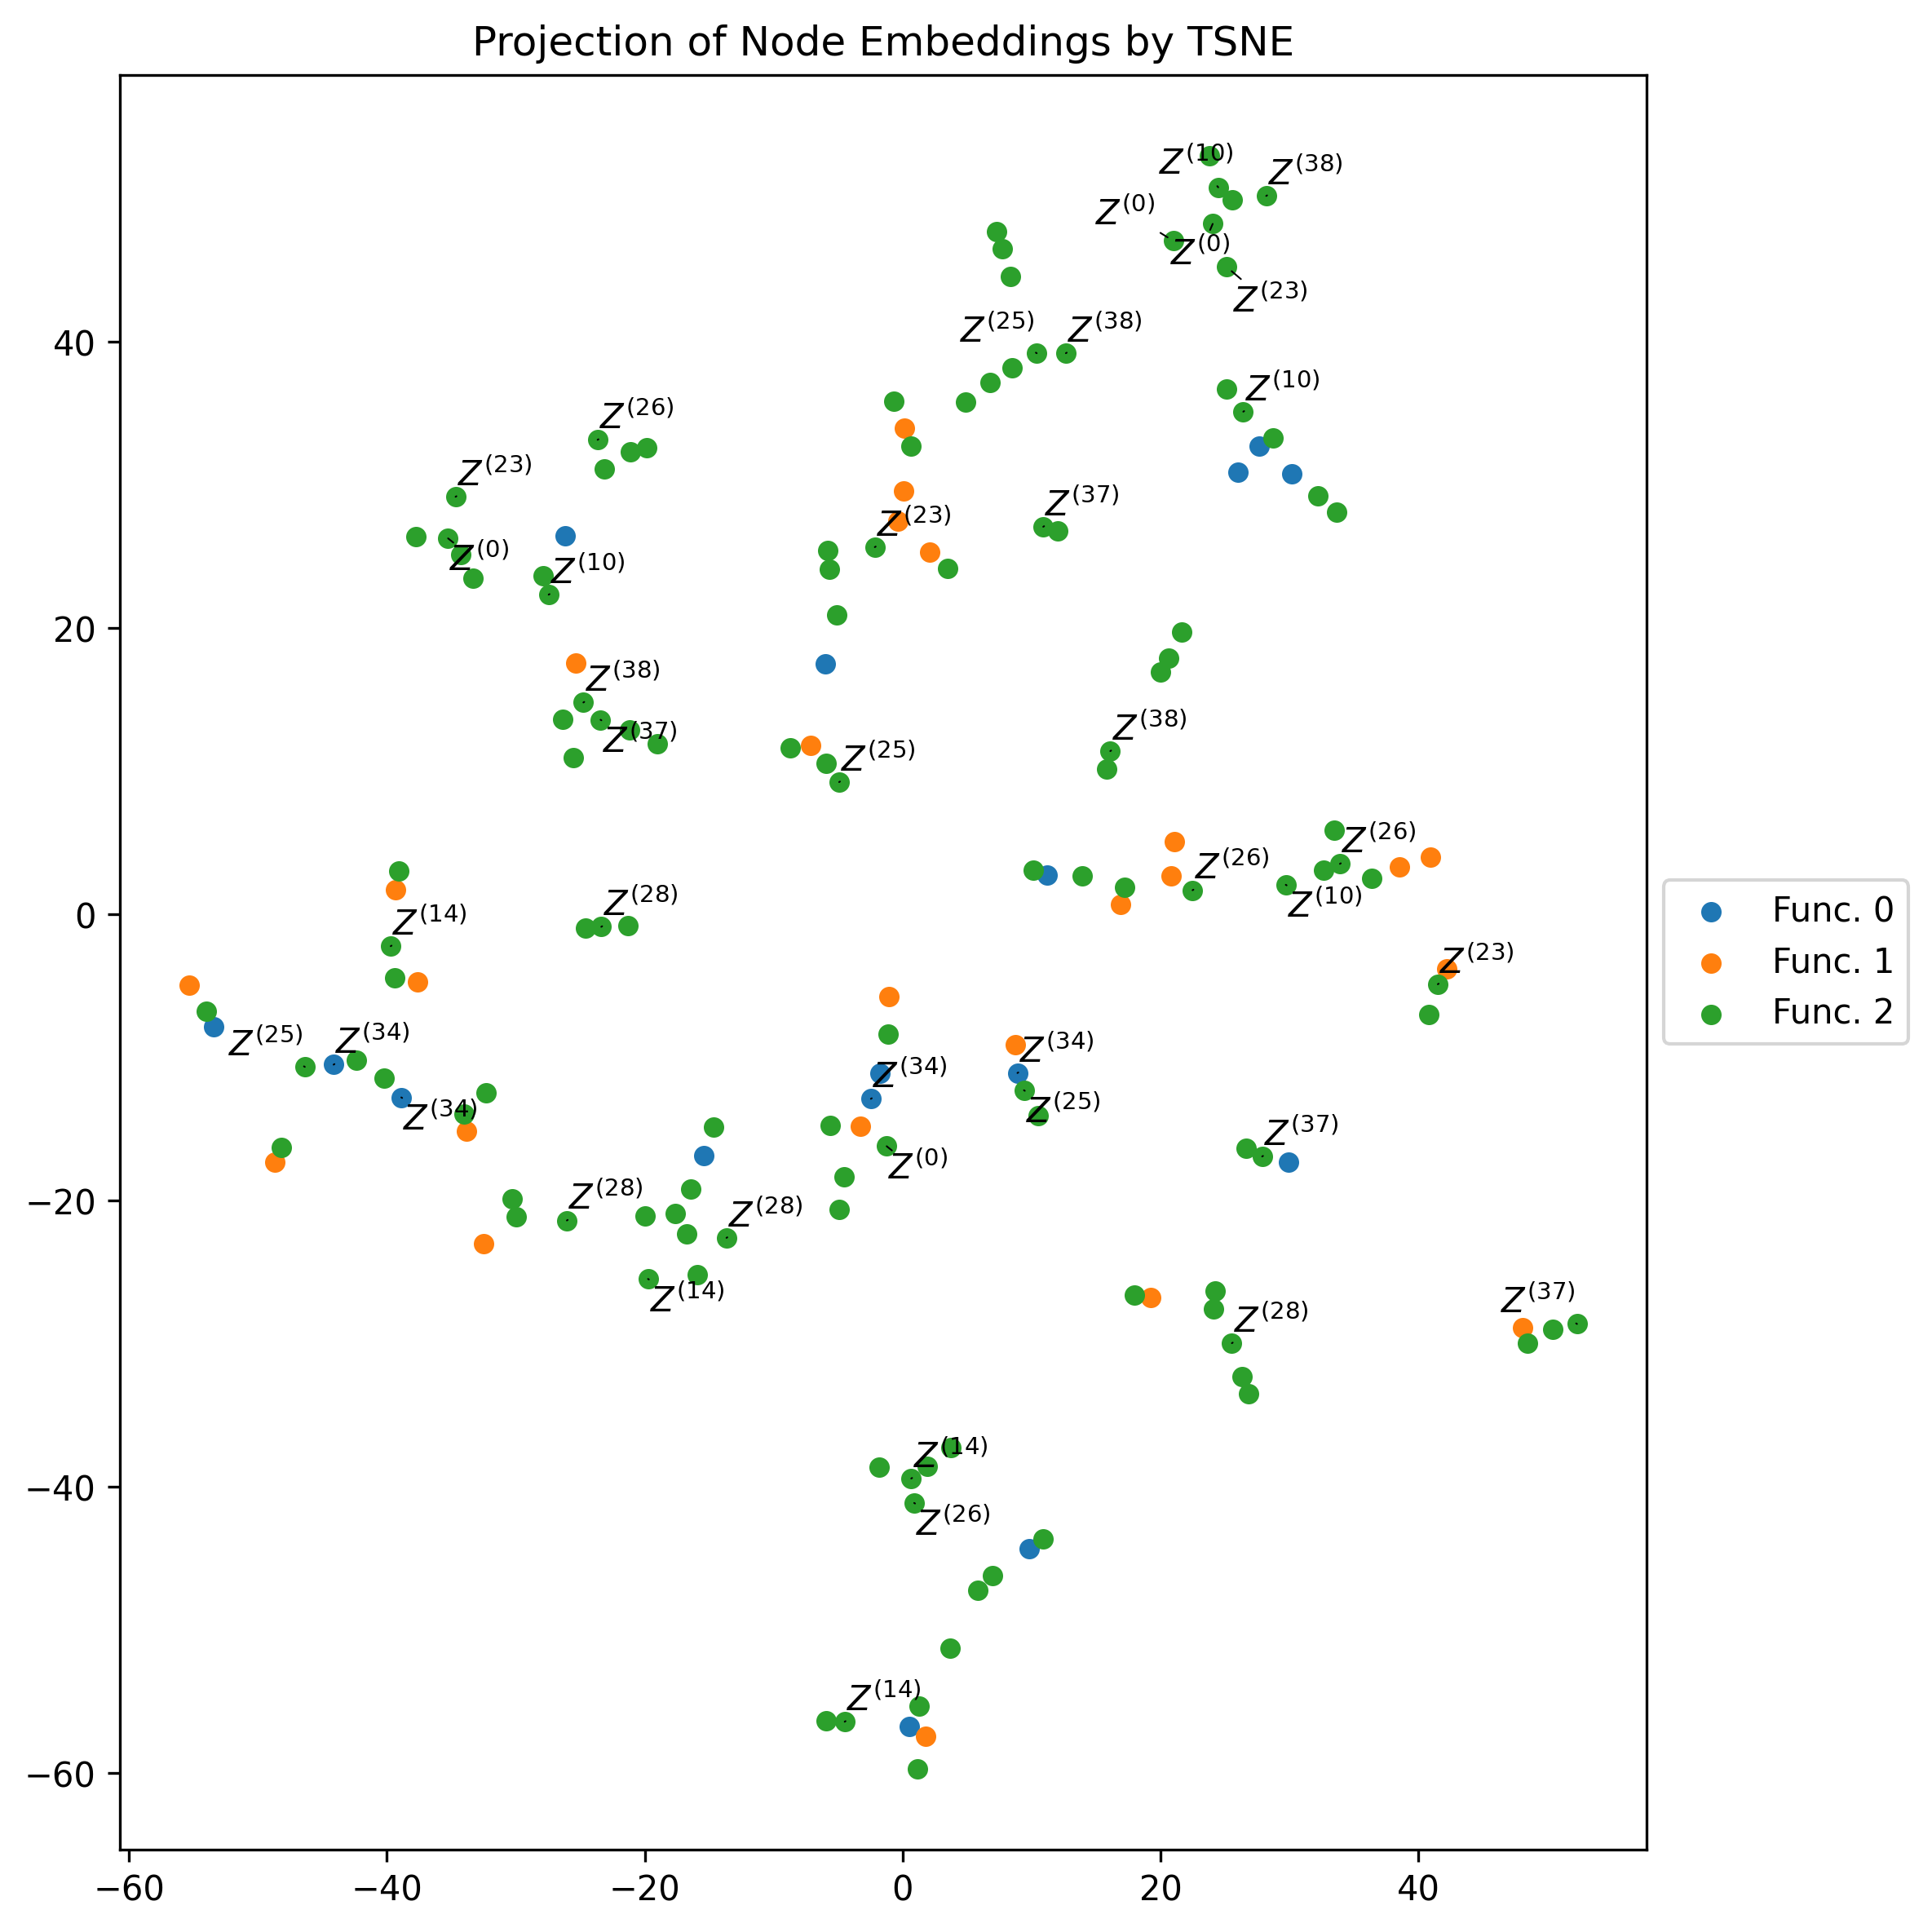

In [70]:
plot_embeddings(
    TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X),
    Y_g,
    label_frmt="Func. {}",
    method="TSNE",
    point_labels=Zidx.astype(int),
    filter_=best_particles["A"],
)

In [26]:
def plot_embeddings_3d(df, x, y, z, color):
	fig = px.scatter_3d(df, x=x, y=y, z=z, color=color)
	fig.show()

def embedding_to_df(embedding, **kwargs):
	df = pd.DataFrame(embedding, columns=['x', 'y', 'z'])
	for k, v in kwargs.items():
		df[k] = v
	return df

In [27]:
plot_embeddings_3d(
	embedding_to_df(
		UMAP(n_neighbors=6, n_components=3).fit_transform(X),
		Y=Y,
		Zidx=Zidx,
	),
	'x', 'y', 'z', color='Zidx'
)


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../envs/work/lib/python3.9/site-packages/umap/umap_.py", line 221:
    @numba.njit(parallel=True)
    def nn_descent(data, n_neighbors, max_candidates=50,
    ^



In [28]:
plot_embeddings_3d(
	embedding_to_df(
		TSNE(n_components=3, learning_rate='auto', init='random', perplexity=4).fit_transform(X),
		Y=Y,
		Zidx=Zidx,
	),
	'x', 'y', 'z', color='Zidx'
)

## Policies based on Latent Variable Model

### Buffer to stack interventions

In [29]:
class NstepHistory:
    """N-step history of intervention data.
    
    Args:
        n_step: number of steps to store.

    Attributes:
        data: numpy array of shape (n_step, n_vars).
    """
    def __init__(self, *, n_step: int) -> None:
        self.n_step = n_step
        self.reset()

    def __call__(self, **kwargs):
        """Update history with new intervention data.
        
        Args:
            state: numpy array of shape (n_vars,).
        """
        if self.data is None:
            self.data = np.tile(deepcopy(kwargs['state']), (self.n_step, 1))
        else:
            self.data = np.roll(self.data, -1, axis=0)
            self.data[-1:, ...] = deepcopy(kwargs['state'])

    def reset(self):
        """Reset history to None."""
        self.data = None

In [30]:
class History:
    """History of intervention data.

    Args:
        n_vars: number of variables.

    Attributes:
        data: numpy array of shape (steps, n_vars).
    """
    def __init__(self, *, n_vars: int) -> None:
        self.n_vars = n_vars
        self.reset()

    def __call__(self, **kwargs):
        """Update history with new intervention data.
        
        Args:
            state: numpy array of shape (n_vars,).
        """
        self.data = np.concatenate([self.data, deepcopy(kwargs['state'][None, ...])], axis=0)

    def reset(self):
        """Reset history to None."""
        self.data = np.empty((0, self.n_vars))

### EGreedyLLPolicy

In [46]:
class EGreedyLLPolicy:
    """Simple math:`\\epsilon`-greedy policy based on maximum log-likelihood math:`\\log p(D | G, \\Theta)`.

    Args:
        inference_model (dibs.inference.Dibs): inference model
        theta (np.ndarray): sampled parameters
        gs (np.ndarray): sampled graphs
        inter_mask (np.ndarray): intervention masks
        action_shape (int): action shape
        n_step (int): number of steps to look behind
        force_exploration (int): number of steps to force exploration,
        buffer (class): buffer to store intervention data
        best_particles (dict): dictionary of best particles for each hypotheses
        topk (int): number of best particles to consider wrt. log-likelihood
    """

    def __init__(
        self,
        *,
        inference_model,
        thetas,
        gs,
        inter_mask,
        action_space: int,
        n_step: int,
        force_exploration: int,
        buffer,
        best_particles: dict,
        topk: int,
    ) -> None:
        self.inference_model = inference_model
        self.thetas = thetas
        self.gs = gs
        self.inter_mask = jnp.array(inter_mask)
        self.action_space = action_space
        self.n_step = n_step
        self.force_exploration = force_exploration
        self.buffer = buffer
        self.best_particles = best_particles
        self.K = topk

        self.log_d_g_t = jax.vmap(
            lambda x, single_g, single_theta: self.inference_model.log_likelihood(
                x=x,
                theta=single_theta,
                g=single_g,
                interv_targets=self.inter_mask[: x.shape[0], ...],
            ),
            (None, 0, 0),
            0,
        )

        self.log_d_g_t_score = jax.vmap(
            lambda x, d, single_g, single_theta: self.inference_model.log_likelihood(
                x=jnp.concatenate([d, x], axis=0),
                theta=single_theta,
                g=single_g,
                interv_targets=self.inter_mask[: d.shape[0]+1, ...],
            ),
            (0, None, 0, 0),
            0,
        )

    def __call__(self, *, state: np.ndarray) -> np.ndarray:
        """Perform action given state

        Args:
            state (np.ndarray): state of agent

        Returns:
            np.ndarray: action
        """
        # Perform random intervention if we are in the first few steps
        if self.force_exploration > self.step_cnt:
            self.step_cnt += 1
            return self.action_space.sample(), None

        else:
            # Update buffer and compute log likelihood of data given sampled parameters
            self.buffer(state=state)

            # Compute the log likelihood of the data given the sampled parameters
            log_d_g_t_list = self.log_d_g_t(jnp.array(self.buffer.data), self.gs, self.thetas)
            log_d_g_t_list = np.array(log_d_g_t_list)

            # Pick the topk particle that maximizes the log likelihood
            mll = np.argpartition(log_d_g_t_list, -self.K)[-self.K:]
            

            # Belief set over hypotheses
            belief_set = set()
            for key in self.best_particles:
                for ml in mll:
                    if ml in self.best_particles[key]:
                        belief_set.add(key)
            belief_set = list(belief_set)
            print(f"Belief set: {belief_set}")

            self.step_cnt += 1
            return self.construct_action(mll, log_d_g_t_list[mll])

    def construct_action(self, mll, log_d_g_t_belief_set):
        """Construct action given belief set and particle index

        Args:
            belief_set: Subset of hypotheses that are consistent with the data
            z_idx: Index of particle that maximizes the log likelihood
            log_d_g_t_belief_set: Log likelihood of data given the belief set

        Returns:
            action: intervention action
        """
        # pick a hypothesis from the belief set
        hyp = np.random.choice(mll, p=softmax(np.exp(log_d_g_t_belief_set)))

        z_idx = np.random.choice(['A', 'B', 'C', 'AB', 'AC', 'BC', 'ABC'])
        for key in best_particles.keys():
            if hyp in best_particles[key]:
                z_idx = key
                break

        action = np.random.randint(2, size=len(self.action_space))
        val = np.random.randint(0, 2)
        for idx, symbol in enumerate(['A', 'B', 'C']):
            if symbol in z_idx:
                action[idx] = val
        print(f"Hyp: {z_idx}, Action: {action}")
        return action, z_idx


    def construct_action_hard_coded(self, belief_set, z_idx, log_d_g_t_belief_set):
        """Construct action given belief set and particle index

        Args:
            belief_set: Subset of hypotheses that are consistent with the data
            z_idx: Index of particle that maximizes the log likelihood
            log_d_g_t_belief_set: Log likelihood of data given the belief set

        Returns:
            action: intervention action
        """
        # pick a hypothesis from the belief set
        hyp = np.random.choice(list(belief_set), p=softmax(log_d_g_t_belief_set))
        action = np.random.randint(2, size=len(self.action_space))
        val = np.random.randint(0, 2)
        for idx, symbol in enumerate(['A', 'B', 'C']):
            if symbol in hyp:
                action[idx] = val
        print(f"Hyp: {hyp}, Action: {action}")
        return action

    def reset(self, *args, **kwargs) -> None:
        """Reset policy"""
        self.buffer.reset()
        self.step_cnt = 0

In [47]:
class RandomLLPolicy:
    """Simple random policy based on maximum log-likelihood math:`\\log p(D | G, \\Theta)`.

    Args:
        inference_model (dibs.inference.Dibs): inference model
        theta (np.ndarray): sampled parameters
        gs (np.ndarray): sampled graphs
        inter_mask (np.ndarray): intervention masks
        action_shape (int): action shape
        n_step (int): number of steps to look behind
        force_exploration (int): number of steps to force exploration,
        buffer (class): buffer to store intervention data
        best_particles (dict): dictionary of best particles for each hypotheses
        topk (int): number of best particles to consider wrt. log-likelihood
    """

    def __init__(
        self,
        *,
        inference_model,
        thetas,
        gs,
        inter_mask,
        action_space: int,
        n_step: int,
        force_exploration: int,
        buffer,
        best_particles: dict,
        topk: int,
    ) -> None:
        self.inference_model = inference_model
        self.thetas = thetas
        self.gs = gs
        self.inter_mask = jnp.array(inter_mask)
        self.action_space = action_space
        self.n_step = n_step
        self.force_exploration = force_exploration
        self.buffer = buffer
        self.best_particles = best_particles
        self.K = topk

        self.log_d_g_t = jax.vmap(
            lambda x, single_g, single_theta: self.inference_model.log_likelihood(
                x=x,
                theta=single_theta,
                g=single_g,
                interv_targets=self.inter_mask[: x.shape[0], ...],
            ),
            (None, 0, 0),
            0,
        )


    def __call__(self, *, state: np.ndarray) -> np.ndarray:
        """Perform action given state

        Args:
            state (np.ndarray): state of agent

        Returns:
            np.ndarray: action
        """
        # Perform random intervention if we are in the first few steps
        if self.force_exploration > self.step_cnt:
            self.step_cnt += 1
            return self.action_space.sample(), None

        else:
            # Update buffer and compute log likelihood of data given sampled parameters
            self.buffer(state=state)

            # Compute the log likelihood of the data given the sampled parameters
            log_d_g_t_list = self.log_d_g_t(jnp.array(self.buffer.data), self.gs, self.thetas)
            log_d_g_t_list = np.array(log_d_g_t_list)

            # Pick the topk particle that maximizes the log likelihood
            mll = np.argmax(log_d_g_t_list)

            # Belief set over hypotheses
            belief_set = set()
            for key in self.best_particles:
                if mll in self.best_particles[key]:
                    belief_set.add(key)
            belief_set = list(belief_set)
            print(f"Belief set: {belief_set}")

            self.step_cnt += 1
            return self.action_space.sample(), belief_set

    def reset(self, *args, **kwargs) -> None:
        """Reset policy"""
        self.buffer.reset()
        self.step_cnt = 0

In [48]:
def compress_pickle(fname: str, data):
    """Compress & save data as pickle file at given path
    Args:
        fname (str): File path
        data (Any): Serializable object
    """
    with bz2.BZ2File(fname, "wb") as f:
        cPickle.dump(data, f)


def decompress_pickle(fname: str):
    """Decompress pickle file at given path
    Args:
        fname (str): Path to file
    Returns:
        Serializable object
    """
    data = bz2.BZ2File(fname, "rb")
    data = cPickle.load(data)
    return data


def make_dirs(directory: str):
    """Make dir path if it does not exist"""
    Path(directory).mkdir(parents=True, exist_ok=True)


class Logger:
    def __init__(self, *, log_dir: str) -> None:
        self.log_dir = log_dir
        make_dirs(log_dir)
        self.log = []
        self.current_log = []

    def reset(self, **kwargs) -> None:
        self.current_param = kwargs
        self.current_log = []

    def push(self) -> None:
        self.log.append([self.current_param, self.current_log])

    def step(self, **kwargs) -> None:
        self.current_log.append(kwargs)

    def save(self, *, file_name: str) -> None:
        compress_pickle(join(self.log_dir, file_name), self.log)


def class_to_hyp(name):
    if 'conj' in name:
        name = name.split('conj')[0][-2:]
    else:
        name = name.split('disj')[0][-1]
    return name


def evaluate_policy(*, policy, env_cfg: dict, n_episodes: int, log: Logger):
    """Evaluate agent using given policy

    Args:
        policy (Policy): Policy to evaluate
        env_cfg (dict): environment configuration
        n_episodes (int): number of episodes to evaluate for
        log (Logger): Logger to store evaluation information

    Returns:
        list: rewards for each episode
        Logger: Logger with evaluation information
    """
    env = CausalEnv_v0(env_cfg)
    eps_rew = []
    for e in range(n_episodes):
        state = env.reset()
        # Reset policy
        policy.reset()
        log.reset(hyp=HYPS[class_to_hyp(str(env._current_gt_hypothesis))])
        ep_rew = 0
        done = False
        while not done:
            action, hyp = policy(state=state)
            next_state, reward, done, info = env.step(action)
            log.step(state=state, reward=reward, hyp=hyp)
            state = next_state
            ep_rew += reward
        log.push()
        eps_rew.append(ep_rew)
    return eps_rew, log

In [49]:
def read_experiment_config(path: str) -> dict:
    """Read experiment configuration from file.

    Args:
        path (str): path to experiment configuration file

    Returns:
        dict: experiment configuration
    """
    with open(path, "r") as f:
        exp_config = EasyDict(yaml.load(f, Loader=yaml.FullLoader))
        ldict = {}
        exec(exp_config['env']['hypotheses'], globals(), ldict)
        exp_config['env']['hypotheses'] = ldict["hypotheses"]

    return exp_config

In [50]:
exp_config = read_experiment_config("config/exp_config.yaml")

In [51]:
policy_greedy = EGreedyLLPolicy(
    inference_model=dibs.inference_model,
    thetas=theta,
    gs=gs,
    inter_mask=inter_mask,
    action_space=env.action_space,
    n_step=5,
    force_exploration=5,
    buffer=History(n_vars=env.observation_space.shape[0]),
    best_particles=best_particles,
    topk=2,
)

In [52]:
policy_random = RandomLLPolicy(
    inference_model=dibs.inference_model,
    thetas=theta,
    gs=gs,
    inter_mask=inter_mask,
    action_space=env.action_space,
    n_step=5,
    force_exploration=5,
    buffer=History(n_vars=env.observation_space.shape[0]),
    best_particles=best_particles,
    topk=5,
)

In [53]:
rewards, log = evaluate_policy(policy=policy_random, env_cfg=exp_config['env'], n_episodes=exp_config.get("n_episodes", 10), log=Logger(log_dir="logs/p_random/"))
log.save(file_name="random.pkl")

Belief set: ['ABC']
Belief set: ['CA', 'C']
Belief set: ['CA', 'C']
Belief set: ['A', 'CA', 'C']
Belief set: ['A', 'CA', 'C']
Belief set: ['A', 'CA', 'C']
Belief set: ['A', 'CA', 'C']
Belief set: ['A', 'CA', 'C']
Belief set: ['A', 'CA', 'C']
Belief set: ['A', 'CA', 'C']
Belief set: ['A', 'CA', 'C']
Belief set: ['A', 'CA', 'C']
Belief set: ['A', 'CA', 'C']
Belief set: ['A', 'CA', 'C']
Belief set: ['A', 'CA', 'C']
Belief set: ['CA', 'C']
Belief set: ['CA', 'C']
Belief set: ['B']
Belief set: ['BC', 'C']
Belief set: ['CA', 'ABC', 'AB']
Belief set: ['ABC', 'BC']
Belief set: ['CA', 'ABC', 'AB']
Belief set: ['CA', 'ABC', 'AB']
Belief set: ['CA', 'ABC', 'AB']
Belief set: ['CA', 'ABC', 'AB']
Belief set: ['A', 'CA', 'C']
Belief set: ['CA', 'ABC', 'AB']
Belief set: ['CA', 'ABC', 'AB']
Belief set: ['ABC', 'BC']
Belief set: ['CA', 'ABC', 'AB']
Belief set: ['CA', 'ABC', 'AB']
Belief set: ['CA', 'ABC', 'AB']
Belief set: ['CA', 'ABC', 'AB']
Belief set: ['CA', 'ABC', 'AB']
Belief set: ['A', 'CA', 'C']


In [54]:
rewards, log = evaluate_policy(policy=policy_greedy, env_cfg=exp_config['env'], n_episodes=exp_config.get("n_episodes", 10), log=Logger(log_dir="logs/p_greedy/"))
log.save(file_name="greedy.pkl")

Belief set: ['A', 'ABC', 'AB', 'B']
Hyp: A, Action: [1 1 1]
Belief set: ['CA', 'ABC', 'BC']
Hyp: BC, Action: [0 0 0]
Belief set: ['CA', 'ABC', 'BC']
Hyp: ABC, Action: [1 1 1]
Belief set: ['CA', 'ABC', 'BC']
Hyp: CA, Action: [1 1 1]
Belief set: ['CA', 'ABC', 'BC']
Hyp: BC, Action: [0 0 0]
Belief set: ['CA', 'ABC', 'BC']
Hyp: CA, Action: [1 1 1]
Belief set: ['CA', 'ABC', 'BC']
Hyp: CA, Action: [0 1 0]
Belief set: ['A', 'AB']
Hyp: A, Action: [1 1 1]
Belief set: ['A', 'AB']
Hyp: AB, Action: [1 1 1]
Belief set: ['A', 'AB']
Hyp: A, Action: [0 1 0]
Belief set: ['AB']
Hyp: AB, Action: [1 1 0]
Belief set: ['AB']
Hyp: AB, Action: [1 1 0]
Belief set: ['A', 'AB']
Hyp: A, Action: [1 0 0]
Belief set: ['AB']
Hyp: AB, Action: [0 0 1]
Belief set: ['AB']
Hyp: AB, Action: [0 0 0]
Belief set: ['AB']
Hyp: AB, Action: [0 0 1]
Belief set: ['AB']
Hyp: AB, Action: [0 0 1]
Belief set: ['B']
Hyp: B, Action: [0 0 0]
Belief set: ['BC', 'C']
Hyp: C, Action: [0 0 0]
Belief set: ['BC', 'C']
Hyp: C, Action: [1 1 1]
Be